In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coco-2017-dataset


In [ ]:
coco_subdir = '/kaggle/input/coco-2017-dataset/coco2017'

In [ ]:
# Cell 1: Import all required libraries
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
import zipfile
import io
import shutil
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    for f in filenames:
        print("  -", f)


Streaming output truncated to the last 5000 lines.
  - 000000421447.jpg
  - 000000368349.jpg
  - 000000520456.jpg
  - 000000213124.jpg
  - 000000116521.jpg
  - 000000319443.jpg
  - 000000481895.jpg
  - 000000564283.jpg
  - 000000266502.jpg
  - 000000117064.jpg
  - 000000207481.jpg
  - 000000237501.jpg
  - 000000023743.jpg
  - 000000548836.jpg
  - 000000285660.jpg
  - 000000313201.jpg
  - 000000015274.jpg
  - 000000339715.jpg
  - 000000121891.jpg
  - 000000245503.jpg
  - 000000264473.jpg
  - 000000295197.jpg
  - 000000227048.jpg
  - 000000522819.jpg
  - 000000499147.jpg
  - 000000465360.jpg
  - 000000243382.jpg
  - 000000503460.jpg
  - 000000125298.jpg
  - 000000206398.jpg
  - 000000501700.jpg
  - 000000209106.jpg
  - 000000388696.jpg
  - 000000041776.jpg
  - 000000423391.jpg
  - 000000068257.jpg
  - 000000294214.jpg
  - 000000256447.jpg
  - 000000411875.jpg
  - 000000538182.jpg
  - 000000156527.jpg
  - 000000455746.jpg
  - 000000242307.jpg
  - 000000373045.jpg
  - 000000431240.jpg
  - 

Found annotations file: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json
Found images directory: /kaggle/input/coco-2017-dataset/coco2017/train2017
Loading annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json
Filtering annotations...
Dataset initialized with 100 images and 5 categories of interest
Categories being used: ['person', 'car', 'dog', 'cat', 'bicycle']
Visualizing dataset samples:
Loading image from: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000474803.jpg
Loading image from: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000503980.jpg
Loading image from: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000348359.jpg
Loading image from: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000535135.jpg
Loading image from: /kaggle/input/coco-2017-dataset/coco2017/train2017/000000278715.jpg


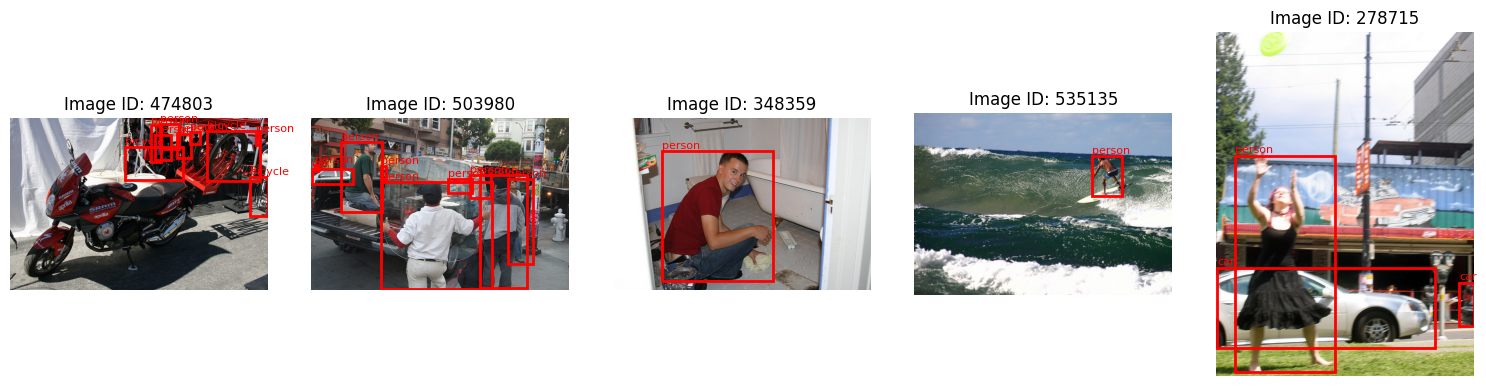

In [ ]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define paths for Kaggle
KAGGLE_INPUT_DIR = '/kaggle/input/coco-2017-dataset'
PROJECT_DIR = '/kaggle/working/object_detection_project'
os.makedirs(PROJECT_DIR, exist_ok=True)

# Try different possible directory structures for COCO dataset in Kaggle
possible_annotation_paths = [
    os.path.join(KAGGLE_INPUT_DIR, "annotations", "instances_train2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "annotations_trainval2017", "annotations", "instances_train2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "annotations", "instances_train2017.json")
]

possible_image_dirs = [
    os.path.join(KAGGLE_INPUT_DIR, "train2017"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "train2017")
]

class COCODetectionDataset:
    def __init__(self, annotations_file, images_dir, categories_of_interest=None, max_images=1000):
        """
        Initialize the COCO dataset

        Args:
            annotations_file: Path to COCO annotations file
            images_dir: Path to directory containing images
            categories_of_interest: List of category names to use (default: person and car)
            max_images: Maximum number of images to use
        """
        self.images_dir = images_dir
        self.max_images = max_images

        # Default categories if none provided
        if categories_of_interest is None:
            self.categories_of_interest = ['person', 'car']
        else:
            self.categories_of_interest = categories_of_interest

        print(f"Loading annotations from {annotations_file}")
        # Load annotations
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create category ID to name mapping
        self.category_id_to_name = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.category_name_to_id = {cat['name']: cat['id'] for cat in self.coco_data['categories']}

        # Filter categories of interest
        self.category_ids_of_interest = []
        for cat in self.categories_of_interest:
            if cat in self.category_name_to_id:
                self.category_ids_of_interest.append(self.category_name_to_id[cat])
            else:
                print(f"Warning: Category '{cat}' not found in dataset")

        # Create image ID to filename mapping
        self.image_id_to_file = {img['id']: img['file_name'] for img in self.coco_data['images']}

        # Filter annotations to only include categories of interest
        print("Filtering annotations...")
        self.filtered_annotations = [
            ann for ann in self.coco_data['annotations']
            if ann['category_id'] in self.category_ids_of_interest
        ]

        # Group annotations by image
        self.annotations_by_image = {}
        for ann in self.filtered_annotations:
            image_id = ann['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(ann)

        # Filter images to only include those with annotations of interest
        self.image_ids = list(self.annotations_by_image.keys())

        # Limit number of images
        if max_images and len(self.image_ids) > max_images:
            self.image_ids = random.sample(self.image_ids, max_images)
            # Update annotations_by_image to only include selected images
            self.annotations_by_image = {
                img_id: self.annotations_by_image[img_id]
                for img_id in self.image_ids
            }

        print(f"Dataset initialized with {len(self.image_ids)} images and {len(self.category_ids_of_interest)} categories of interest")
        print(f"Categories being used: {[self.category_id_to_name[cat_id] for cat_id in self.category_ids_of_interest]}")

    def get_image_path(self, image_id):
        """Get path to image file"""
        filename = self.image_id_to_file[image_id]
        return os.path.join(self.images_dir, filename)

    def visualize_sample(self, num_samples=5):
        """Visualize random samples from the dataset"""
        sample_image_ids = random.sample(self.image_ids, min(num_samples, len(self.image_ids)))

        fig, axes = plt.subplots(1, len(sample_image_ids), figsize=(15, 5))
        if len(sample_image_ids) == 1:
            axes = [axes]

        for i, img_id in enumerate(sample_image_ids):
            try:
                # Load image
                image_path = self.get_image_path(img_id)
                print(f"Loading image from: {image_path}")
                img = Image.open(image_path)

                # Get annotations
                annotations = self.annotations_by_image[img_id]

                # Plot image
                axes[i].imshow(img)
                axes[i].set_title(f"Image ID: {img_id}")
                axes[i].axis('off')

                # Draw bounding boxes
                for ann in annotations:
                    x, y, w, h = ann['bbox']
                    category_id = ann['category_id']
                    category_name = self.category_id_to_name[category_id]

                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                    axes[i].text(x, y-5, category_name, color='r', fontsize=8)
            except Exception as e:
                print(f"Error visualizing image {img_id}: {e}")
                if len(sample_image_ids) > 1:
                    axes[i].text(0.5, 0.5, f"Error: {str(e)}", ha='center')
                else:
                    print(f"Cannot visualize: {str(e)}")

        plt.tight_layout()
        plt.show()

def find_valid_paths():
    """Find valid annotation file and images directory"""
    annotations_file = None
    images_dir = None

    # Check for annotations file
    for path in possible_annotation_paths:
        if os.path.exists(path):
            annotations_file = path
            print(f"Found annotations file: {annotations_file}")
            break

    # Check for images directory
    for path in possible_image_dirs:
        if os.path.exists(path):
            images_dir = path
            print(f"Found images directory: {images_dir}")
            break

    # List available directories to help debug
    if annotations_file is None or images_dir is None:
        print("\nAvailable directories in Kaggle input:")
        for root, dirs, files in os.walk(KAGGLE_INPUT_DIR, topdown=True, maxdepth=3):
            print(f"Directory: {root}")
            for d in dirs:
                print(f"  - {d}/")
            for f in files[:5]:  # Show only first 5 files to avoid clutter
                print(f"  + {f}")
            if len(files) > 5:
                print(f"  + ... ({len(files)-5} more files)")

    return annotations_file, images_dir

def main():
    # Find valid paths for Kaggle environment
    annotations_file, images_dir = find_valid_paths()

    if annotations_file is None:
        raise FileNotFoundError("Cannot find annotations file. Please check the dataset structure.")

    if images_dir is None:
        raise FileNotFoundError("Cannot find images directory. Please check the dataset structure.")

    # Categories to detect
    categories_of_interest = ['person', 'car', 'dog', 'cat', 'bicycle']

    # Initialize the dataset with proper error handling
    try:
        coco_dataset = COCODetectionDataset(
            annotations_file=annotations_file,
            images_dir=images_dir,
            categories_of_interest=categories_of_interest,
            max_images=100  # Use fewer images for faster testing
        )

        # Visualize some samples
        print("Visualizing dataset samples:")
        coco_dataset.visualize_sample(5)
    except Exception as e:
        print(f"Error initializing dataset: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Found training annotations file: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json
Found training images directory: /kaggle/input/coco-2017-dataset/coco2017/train2017
Found validation annotations file: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
Found validation images directory: /kaggle/input/coco-2017-dataset/coco2017/val2017
Using device: cuda
Loading annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json
Filtering annotations...
Dataset initialized with 500 images and 5 categories of interest
Categories being used: ['person', 'car', 'dog', 'cat', 'bicycle']
Loading annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
Filtering annotations...
Dataset initialized with 100 images and 5 categories of interest
Categories being used: ['person', 'car', 'dog', 'cat', 'bicycle']
Visualizing training dataset samples:
Loading image from: /kaggle/input/coc

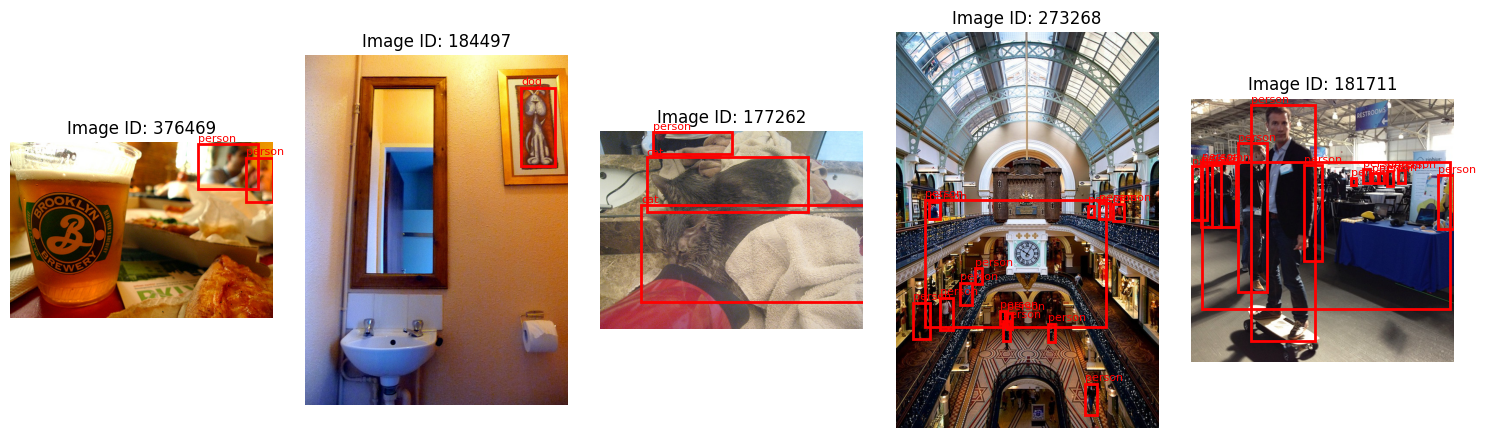


--------------------------------------------------
Training and evaluating fasterrcnn_resnet50
--------------------------------------------------
Training fasterrcnn_resnet50...
Epoch 1/2


Epoch 1: 100%|██████████| 250/250 [02:36<00:00,  1.59it/s, loss=0.519]


Epoch 1 loss: 0.5193
Epoch 2/2


Epoch 2: 100%|██████████| 250/250 [02:32<00:00,  1.64it/s, loss=0.387]


Epoch 2 loss: 0.3871
Evaluating fasterrcnn_resnet50...


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  7.95it/s]
<ipython-input-70-8ac9ebe8bed1>:575: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(precisions, recalls)



Evaluation Results for fasterrcnn_resnet50:
mAP@0.5: 0.4271
mAP@0.75: 0.1424

Class-wise metrics:
person: Precision = 0.4242, Recall = 0.7472, F1 = 0.5412
car: Precision = 0.4429, Recall = 0.5000, F1 = 0.4697
dog: Precision = 0.0000, Recall = 0.0000, F1 = 0.0000
cat: Precision = 0.4000, Recall = 1.0000, F1 = 0.5714
bicycle: Precision = 0.2727, Recall = 0.3333, F1 = 0.3000

Average Inference Time: 0.1074 seconds


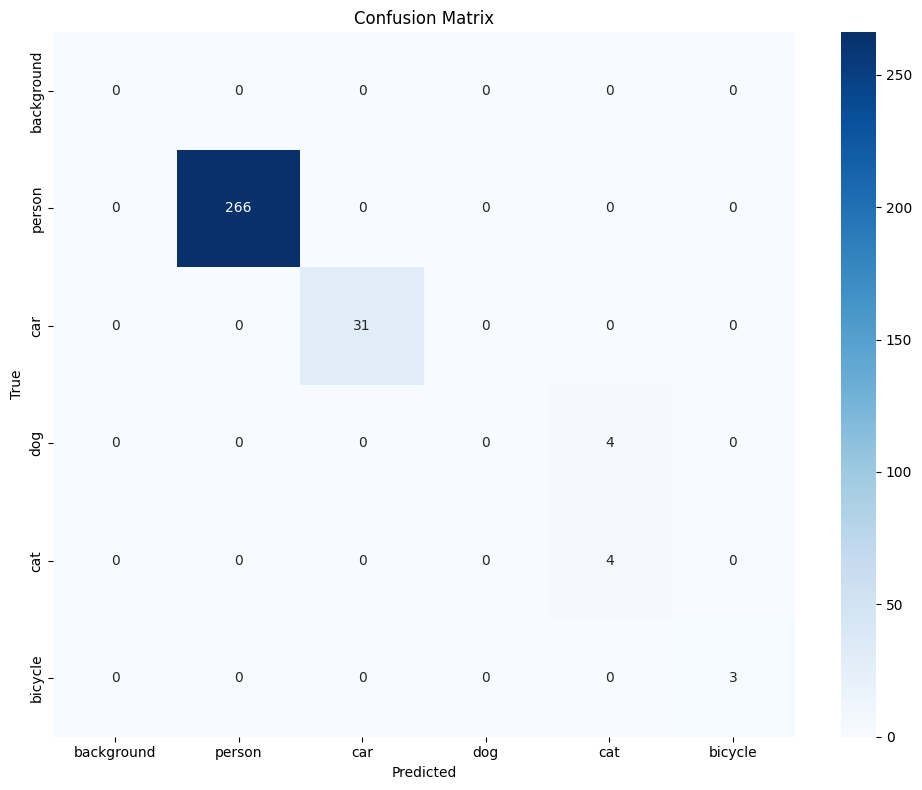


Visualizing predictions for fasterrcnn_resnet50:


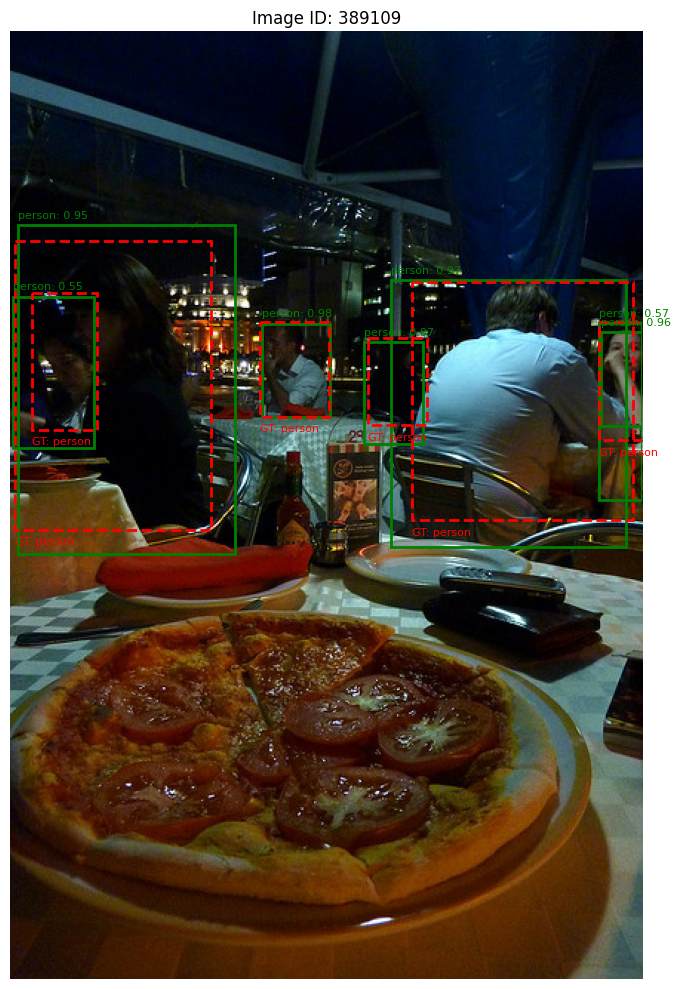

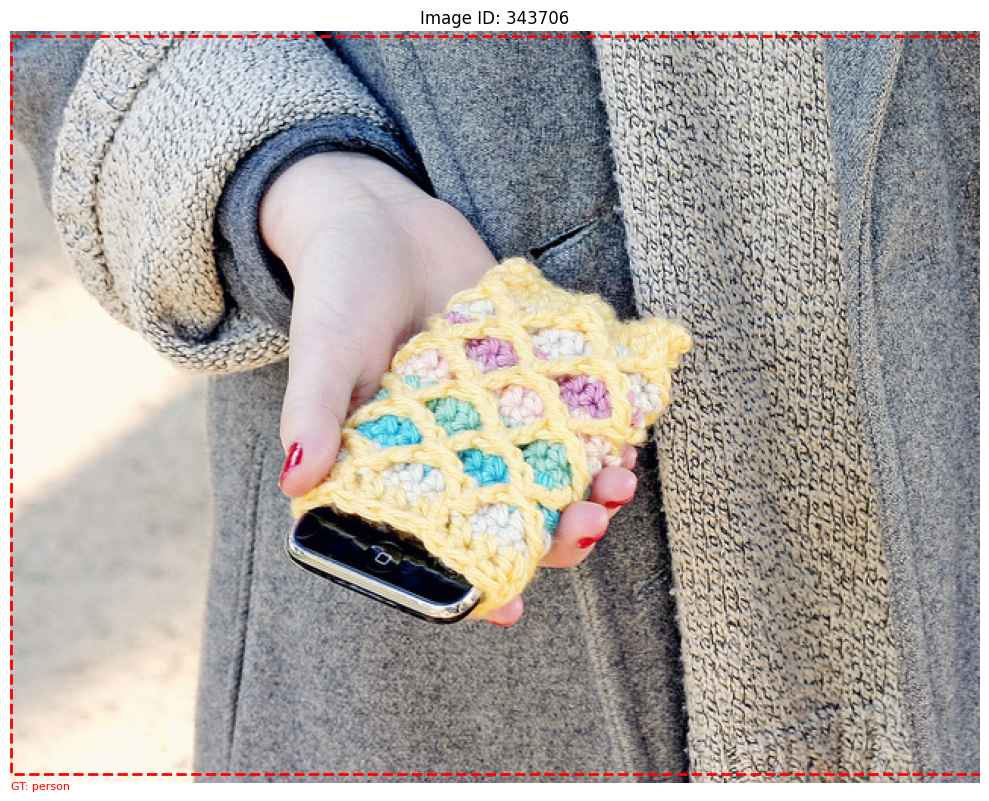

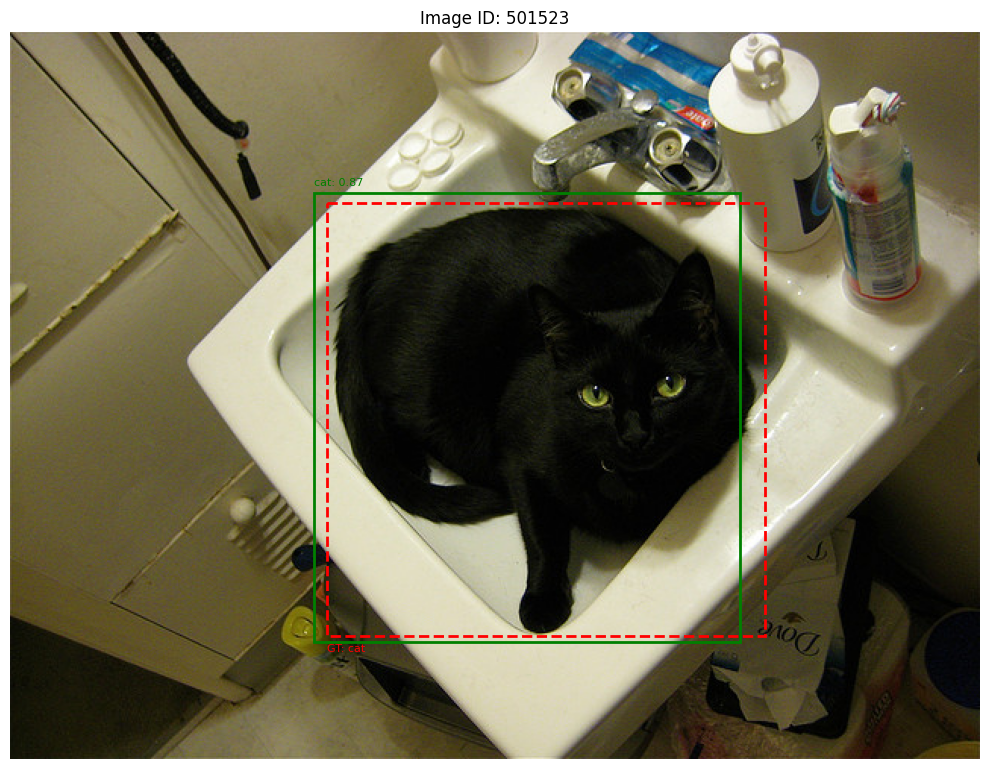

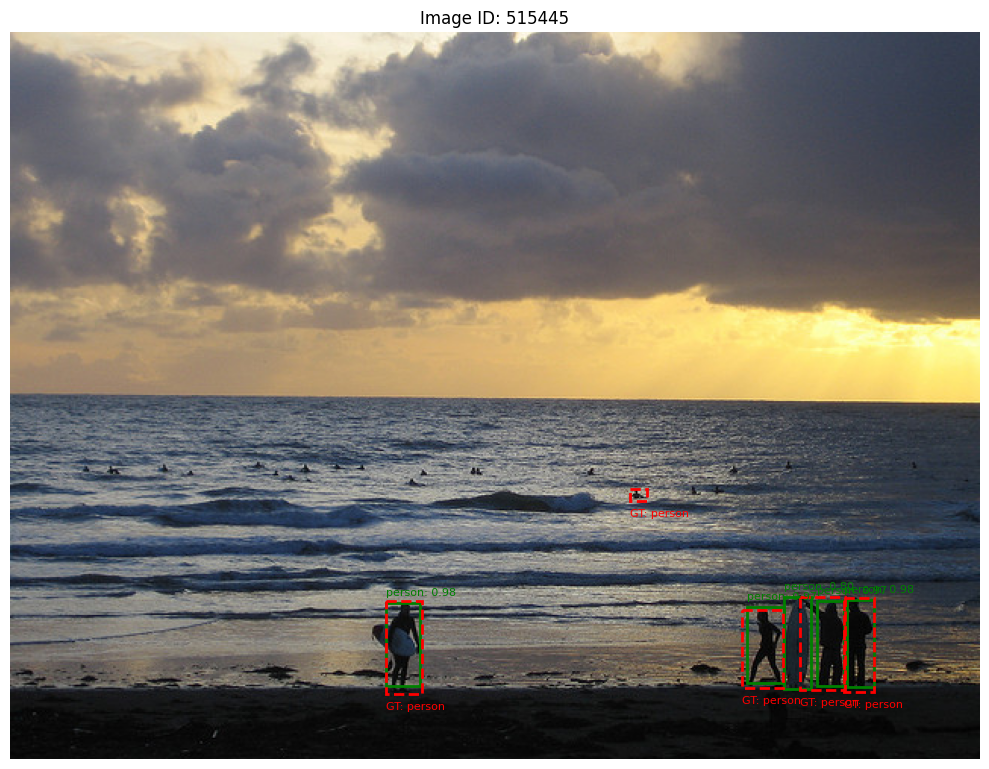

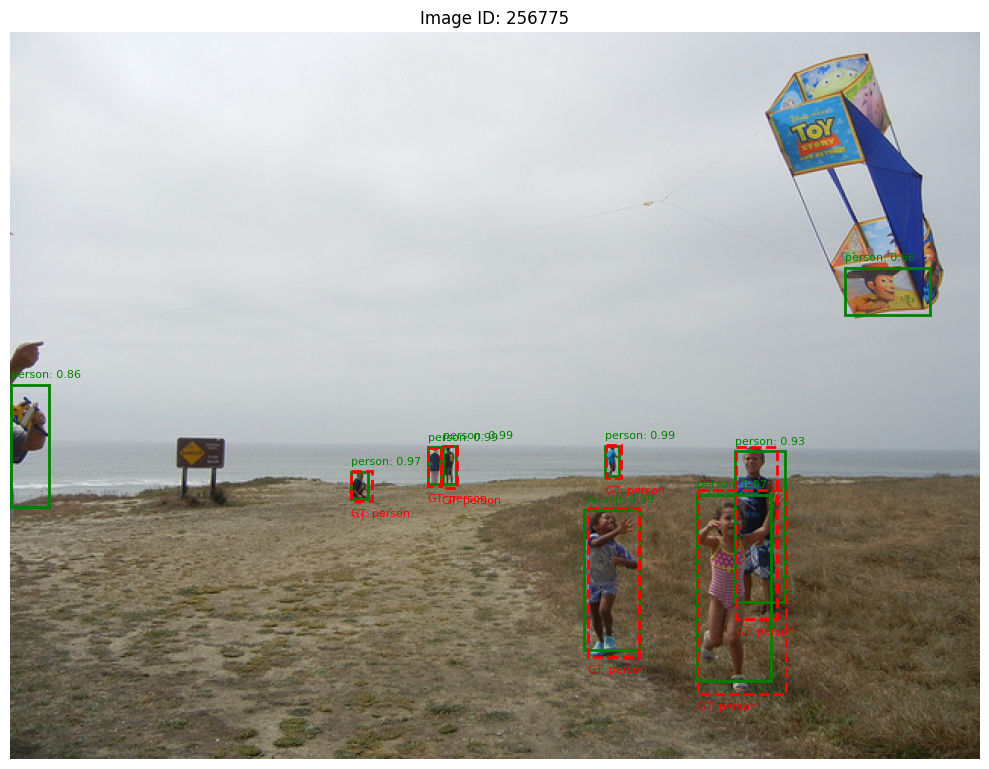

Model saved to /kaggle/working/object_detection_project/fasterrcnn_resnet50.pth

--------------------------------------------------
Training and evaluating ssdlite_mobilenetv3
--------------------------------------------------
Error in main: 'SSDLiteClassificationHead' object has no attribute 'in_channels'


Traceback (most recent call last):
  File "<ipython-input-70-8ac9ebe8bed1>", line 946, in main
    model = get_object_detection_model(model_name, num_classes)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-70-8ac9ebe8bed1>", line 332, in get_object_detection_model
    in_channels=model.head.classification_head.in_channels,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1928, in __getattr__
    raise AttributeError(
AttributeError: 'SSDLiteClassificationHead' object has no attribute 'in_channels'


In [ ]:
import os
import json
import random
import time
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Define paths for Kaggle
KAGGLE_INPUT_DIR = '/kaggle/input/coco-2017-dataset'
PROJECT_DIR = '/kaggle/working/object_detection_project'
os.makedirs(PROJECT_DIR, exist_ok=True)

# Try different possible directory structures for COCO dataset in Kaggle
possible_annotation_paths = [
    os.path.join(KAGGLE_INPUT_DIR, "annotations", "instances_train2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "annotations_trainval2017", "annotations", "instances_train2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "annotations", "instances_train2017.json")
]

possible_image_dirs = [
    os.path.join(KAGGLE_INPUT_DIR, "train2017"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "train2017")
]

possible_val_annotation_paths = [
    os.path.join(KAGGLE_INPUT_DIR, "annotations", "instances_val2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "annotations_trainval2017", "annotations", "instances_val2017.json"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "annotations", "instances_val2017.json")
]

possible_val_image_dirs = [
    os.path.join(KAGGLE_INPUT_DIR, "val2017"),
    os.path.join(KAGGLE_INPUT_DIR, "coco2017", "val2017")
]

class COCODetectionDataset(Dataset):
    def __init__(self, annotations_file, images_dir, categories_of_interest=None, max_images=1000,
                 transform=None, train=True):
        """
        Initialize the COCO dataset for PyTorch

        Args:
            annotations_file: Path to COCO annotations file
            images_dir: Path to directory containing images
            categories_of_interest: List of category names to use
            max_images: Maximum number of images to use
            transform: Optional transform to be applied on a sample
            train: Whether this is for training (True) or testing (False)
        """
        self.images_dir = images_dir
        self.transform = transform
        self.train = train
        self.max_images = max_images

        # Default categories if none provided
        if categories_of_interest is None:
            self.categories_of_interest = ['person', 'car']
        else:
            self.categories_of_interest = categories_of_interest

        print(f"Loading annotations from {annotations_file}")
        # Load annotations
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create category ID to name mapping
        self.category_id_to_name = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.category_name_to_id = {cat['name']: cat['id'] for cat in self.coco_data['categories']}

        # Create a mapping from original category IDs to our consecutive IDs starting from 1
        # 0 is reserved for background in PyTorch object detection
        self.category_ids_of_interest = []
        self.category_id_to_idx = {}
        self.idx_to_category_name = {0: 'background'}  # ID 0 is reserved for background

        idx = 1  # Start from 1 (0 is background)
        for cat in self.categories_of_interest:
            if cat in self.category_name_to_id:
                original_id = self.category_name_to_id[cat]
                self.category_ids_of_interest.append(original_id)
                self.category_id_to_idx[original_id] = idx
                self.idx_to_category_name[idx] = cat
                idx += 1
            else:
                print(f"Warning: Category '{cat}' not found in dataset")

        # Create image ID to filename mapping
        self.image_id_to_file = {img['id']: img['file_name'] for img in self.coco_data['images']}

        # Create image ID to size mapping
        self.image_id_to_size = {img['id']: (img['width'], img['height']) for img in self.coco_data['images']}

        # Filter annotations to only include categories of interest
        print("Filtering annotations...")
        self.filtered_annotations = [
            ann for ann in self.coco_data['annotations']
            if ann['category_id'] in self.category_ids_of_interest
        ]

        # Group annotations by image
        self.annotations_by_image = {}
        for ann in self.filtered_annotations:
            image_id = ann['image_id']
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(ann)

        # Filter images to only include those with annotations of interest
        self.image_ids = list(self.annotations_by_image.keys())

        # Limit number of images
        if max_images and len(self.image_ids) > max_images:
            self.image_ids = random.sample(self.image_ids, max_images)
            # Update annotations_by_image to only include selected images
            self.annotations_by_image = {
                img_id: self.annotations_by_image[img_id]
                for img_id in self.image_ids
            }

        print(f"Dataset initialized with {len(self.image_ids)} images and {len(self.category_ids_of_interest)} categories of interest")
        print(f"Categories being used: {[self.category_id_to_name[cat_id] for cat_id in self.category_ids_of_interest]}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        """Get item by index"""
        image_id = self.image_ids[idx]

        # Load image
        image_path = os.path.join(self.images_dir, self.image_id_to_file[image_id])
        image = Image.open(image_path).convert("RGB")

        # Get annotations for this image
        annotations = self.annotations_by_image[image_id]

        # Extract bounding boxes and labels
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in annotations:
            # Get bounding box
            x, y, w, h = ann['bbox']
            # Convert COCO format [x, y, width, height] to PyTorch format [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])

            # Get category ID and convert to consecutive index
            category_id = ann['category_id']
            labels.append(self.category_id_to_idx[category_id])

            # Get area and iscrowd
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': iscrowd
        }

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, target

    def get_image_path(self, image_id):
        """Get path to image file"""
        filename = self.image_id_to_file[image_id]
        return os.path.join(self.images_dir, filename)

    def visualize_sample(self, num_samples=5, figsize=(15, 5)):
        """Visualize random samples from the dataset"""
        sample_image_ids = random.sample(self.image_ids, min(num_samples, len(self.image_ids)))

        fig, axes = plt.subplots(1, len(sample_image_ids), figsize=figsize)
        if len(sample_image_ids) == 1:
            axes = [axes]

        for i, img_id in enumerate(sample_image_ids):
            try:
                # Load image
                image_path = self.get_image_path(img_id)
                print(f"Loading image from: {image_path}")
                img = Image.open(image_path)

                # Get annotations
                annotations = self.annotations_by_image[img_id]

                # Plot image
                axes[i].imshow(img)
                axes[i].set_title(f"Image ID: {img_id}")
                axes[i].axis('off')

                # Draw bounding boxes
                for ann in annotations:
                    x, y, w, h = ann['bbox']
                    category_id = ann['category_id']
                    category_name = self.category_id_to_name[category_id]

                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                    axes[i].text(x, y-5, category_name, color='r', fontsize=8)
            except Exception as e:
                print(f"Error visualizing image {img_id}: {e}")
                if len(sample_image_ids) > 1:
                    axes[i].text(0.5, 0.5, f"Error: {str(e)}", ha='center')
                else:
                    print(f"Cannot visualize: {str(e)}")

        plt.tight_layout()
        plt.show()


def find_valid_paths():
    """Find valid annotation file and images directory"""
    annotations_file = None
    images_dir = None
    val_annotations_file = None
    val_images_dir = None

    # Check for annotations file
    for path in possible_annotation_paths:
        if os.path.exists(path):
            annotations_file = path
            print(f"Found training annotations file: {annotations_file}")
            break

    # Check for images directory
    for path in possible_image_dirs:
        if os.path.exists(path):
            images_dir = path
            print(f"Found training images directory: {images_dir}")
            break

    # Check for validation annotations file
    for path in possible_val_annotation_paths:
        if os.path.exists(path):
            val_annotations_file = path
            print(f"Found validation annotations file: {val_annotations_file}")
            break

    # Check for validation images directory
    for path in possible_val_image_dirs:
        if os.path.exists(path):
            val_images_dir = path
            print(f"Found validation images directory: {val_images_dir}")
            break

    # List available directories to help debug
    if annotations_file is None or images_dir is None:
        print("\nAvailable directories in Kaggle input:")
        for root, dirs, files in os.walk(KAGGLE_INPUT_DIR, topdown=True):
            depth = root.count(os.sep) - KAGGLE_INPUT_DIR.count(os.sep)
            if depth > 3:  # Limit depth to avoid excessive output
                continue
            print(f"Directory: {root}")
            for d in dirs:
                print(f"  - {d}/")
            for f in files[:5]:  # Show only first 5 files to avoid clutter
                print(f"  + {f}")
            if len(files) > 5:
                print(f"  + ... ({len(files)-5} more files)")

    return annotations_file, images_dir, val_annotations_file, val_images_dir


def collate_fn(batch):
    """Custom collate function for batching with variable size boxes"""
    return tuple(zip(*batch))


def get_object_detection_model(model_name, num_classes, pretrained=True):
    """
    Get an object detection model

    Args:
        model_name: Name of the model ('fasterrcnn_resnet50' or 'ssdlite_mobilenetv3')
        num_classes: Number of classes to detect (including background)
        pretrained: Whether to use pretrained weights

    Returns:
        model: Object detection model
    """
    if model_name == 'fasterrcnn_resnet50':
        # Initialize with pretrained weights
        if pretrained:
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            model = fasterrcnn_resnet50_fpn(weights=weights)
        else:
            model = fasterrcnn_resnet50_fpn(weights=None)

        # Replace the pre-trained head with a new one for our number of classes
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    elif model_name == 'ssdlite_mobilenetv3':
        # Initialize with pretrained weights
        if pretrained:
            weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
            model = ssdlite320_mobilenet_v3_large(weights=weights)
        else:
            model = ssdlite320_mobilenet_v3_large(weights=None)

        # Replace the classification head for our number of classes
        model.head.classification_head = torchvision.models.detection.ssdlite.SSDLiteClassificationHead(
            in_channels=model.head.classification_head.in_channels,
            num_anchors=model.head.classification_head.num_anchors,
            num_classes=num_classes
        )
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    return model


def train_model(model, data_loader, optimizer, device, num_epochs=1):
    """Train the model"""
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        running_loss = 0.0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}")

        for i, (images, targets) in enumerate(progress_bar):
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimize
            losses.backward()
            optimizer.step()

            # Update progress bar
            running_loss += losses.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))

        print(f"Epoch {epoch+1} loss: {running_loss/len(data_loader):.4f}")


def evaluate_model(model, data_loader, device, score_threshold=0.5, iou_threshold=0.5):
    """
    Evaluate model performance

    Args:
        model: Object detection model
        data_loader: DataLoader for test data
        device: Device to run inference on
        score_threshold: Threshold for confidence scores
        iou_threshold: IoU threshold for evaluation

    Returns:
        metrics: Dictionary of evaluation metrics
    """
    model.eval()

    # Initialize metrics
    all_predictions = []
    all_targets = []
    inference_times = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Measure inference time
            start_time = time.time()
            predictions = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            # Filter predictions based on score threshold
            for pred in predictions:
                pred['boxes'] = pred['boxes'][pred['scores'] >= score_threshold]
                pred['labels'] = pred['labels'][pred['scores'] >= score_threshold]
                pred['scores'] = pred['scores'][pred['scores'] >= score_threshold]

            all_predictions.extend(predictions)
            all_targets.extend(targets)

    # Calculate mAP at different IoU thresholds
    map_50, map_75 = calculate_map(all_predictions, all_targets, [0.5, 0.75])

    # Calculate precision, recall, F1-score
    precision, recall, f1, cm = calculate_metrics(all_predictions, all_targets, iou_threshold)

    # Calculate average inference time
    avg_inference_time = sum(inference_times) / len(inference_times)

    metrics = {
        'mAP@0.5': map_50,
        'mAP@0.75': map_75,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'avg_inference_time': avg_inference_time
    }

    return metrics


def calculate_map(predictions, targets, iou_thresholds):
    """
    Calculate mAP at different IoU thresholds

    Args:
        predictions: List of prediction dictionaries
        targets: List of target dictionaries
        iou_thresholds: List of IoU thresholds

    Returns:
        maps: List of mAP values for each IoU threshold
    """
    maps = []

    for iou_threshold in iou_thresholds:
        # Initialize counters
        aps = []

        # Get unique class labels
        unique_labels = set()
        for target in targets:
            unique_labels.update(target['labels'].cpu().numpy())

        # Calculate AP for each class
        for class_id in unique_labels:
            # Collect all detections and ground truths for this class
            all_detections = []
            all_ground_truths = []

            for pred, target in zip(predictions, targets):
                # Get detections for this class
                detection_boxes = pred['boxes'][pred['labels'] == class_id].cpu().numpy()
                detection_scores = pred['scores'][pred['labels'] == class_id].cpu().numpy()

                # Sort by score (descending)
                sort_indices = np.argsort(-detection_scores)
                detection_boxes = detection_boxes[sort_indices]
                detection_scores = detection_scores[sort_indices]

                all_detections.append({
                    'boxes': detection_boxes,
                    'scores': detection_scores
                })

                # Get ground truths for this class
                gt_boxes = target['boxes'][target['labels'] == class_id].cpu().numpy()
                all_ground_truths.append({'boxes': gt_boxes})

            # Calculate AP for this class
            ap = calculate_ap(all_detections, all_ground_truths, iou_threshold)
            if not np.isnan(ap):
                aps.append(ap)

        # Calculate mAP
        if aps:
            maps.append(np.mean(aps))
        else:
            maps.append(0.0)

    return maps


def calculate_ap(all_detections, all_ground_truths, iou_threshold):
    """
    Calculate Average Precision for a single class

    Args:
        all_detections: List of detection dictionaries
        all_ground_truths: List of ground truth dictionaries
        iou_threshold: IoU threshold

    Returns:
        ap: Average Precision
    """
    # Flatten detections and match them to ground truths
    true_positives = []
    false_positives = []
    scores = []

    for img_idx, (detections, ground_truths) in enumerate(zip(all_detections, all_ground_truths)):
        if len(detections['boxes']) == 0:
            continue

        gt_boxes = ground_truths['boxes']
        gt_matched = np.zeros(len(gt_boxes), dtype=bool)

        for detection_idx, (box, score) in enumerate(zip(detections['boxes'], detections['scores'])):
            # Keep track of the score
            scores.append(score)

            if len(gt_boxes) == 0:
                # No ground truths, all detections are false positives
                true_positives.append(0)
                false_positives.append(1)
                continue

            # Calculate IoU with all ground truth boxes
            ious = calculate_iou_batch(box, gt_boxes)

            # Find best matching ground truth
            best_gt_idx = np.argmax(ious)
            best_iou = ious[best_gt_idx]

            if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                # Matched!
                true_positives.append(1)
                false_positives.append(0)
                gt_matched[best_gt_idx] = True
            else:
                # Not matched or already matched
                true_positives.append(0)
                false_positives.append(1)

    # If no detections, return 0 AP
    if not scores:
        return 0.0

    # Convert to numpy arrays
    true_positives = np.array(true_positives)
    false_positives = np.array(false_positives)
    scores = np.array(scores)

    # Sort by score (highest first)
    sort_indices = np.argsort(-scores)
    true_positives = true_positives[sort_indices]
    false_positives = false_positives[sort_indices]

    # Calculate precision and recall
    true_positives_cumsum = np.cumsum(true_positives)
    false_positives_cumsum = np.cumsum(false_positives)
    recalls = true_positives_cumsum / np.sum([len(gt['boxes']) for gt in all_ground_truths])
    precisions = true_positives_cumsum / (true_positives_cumsum + false_positives_cumsum)

    # Add start point
    precisions = np.concatenate([[1.0], precisions])
    recalls = np.concatenate([[0.0], recalls])

    # Calculate area under PR curve
    return np.trapz(precisions, recalls)


def calculate_iou_batch(box, boxes):
    """
    Calculate IoU between a box and a batch of boxes

    Args:
        box: Single box [x1, y1, x2, y2]
        boxes: Batch of boxes [N, 4]

    Returns:
        ious: IoU values [N]
    """
    # Calculate intersection area
    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    intersection_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

    # Calculate union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


def calculate_metrics(predictions, targets, iou_threshold):
    """
    Calculate precision, recall, F1-score, and confusion matrix

    Args:
        predictions: List of prediction dictionaries
        targets: List of target dictionaries
        iou_threshold: IoU threshold

    Returns:
        precision: Precision values per class
        recall: Recall values per class
        f1: F1-score values per class
        cm: Confusion matrix
    """
    # Get all unique class labels
    all_labels = set()
    for target in targets:
        all_labels.update(target['labels'].cpu().numpy())
    num_classes = max(all_labels) + 1  # +1 for background class

    # Initialize confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)

    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()

        # Initialize array to track which GT boxes have been matched
        gt_matched = np.zeros(len(gt_boxes), dtype=bool)

        # Match predictions to ground truth
        for i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
            # Calculate IoU with all ground truth boxes
            if len(gt_boxes) > 0:
                ious = calculate_iou_batch(pred_box, gt_boxes)
                # Find best matching ground truth
                best_gt_idx = np.argmax(ious)
                best_iou = ious[best_gt_idx]

                if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                    # Matched!
                    gt_matched[best_gt_idx] = True
                    gt_label = gt_labels[best_gt_idx]
                    cm[gt_label][pred_label] += 1  # Update confusion matrix

                    if pred_label == gt_label:
                        # True positive
                        true_positives[pred_label] += 1
                    else:
                        # Wrong class prediction
                        false_positives[pred_label] += 1
                        false_negatives[gt_label] += 1
                else:
                    # Not matched or already matched
                    false_positives[pred_label] += 1
            else:
                # No ground truths, all predictions are false positives
                false_positives[pred_label] += 1

        # Count unmatched ground truths as false negatives
        for i, matched in enumerate(gt_matched):
            if not matched:
                false_negatives[gt_labels[i]] += 1

    # Calculate metrics
    precision = []
    recall = []
    f1 = []

    for i in range(1, num_classes):  # Skip background class
        if true_positives[i] + false_positives[i] > 0:
            p = true_positives[i] / (true_positives[i] + false_positives[i])
        else:
            p = 0.0

        if true_positives[i] + false_negatives[i] > 0:
            r = true_positives[i] / (true_positives[i] + false_negatives[i])
        else:
            r = 0.0

        if p + r > 0:
            f = 2 * p * r / (p + r)
        else:
            f = 0.0

        precision.append(p)
        recall.append(r)
        f1.append(f)

    return precision, recall, f1, cm


def visualize_predictions(model, dataset, device, num_images=10, score_threshold=0.5):
    """
    Visualize model predictions

    Args:
        model: Object detection model
        dataset: Dataset
        device: Device to run inference on
        num_images: Number of images to visualize
        score_threshold: Threshold for confidence scores
    """
    model.eval()

    # Sample random images
    image_indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    for idx in image_indices:
        image, target = dataset[idx]
        image_id = target['image_id'].item()
        original_image = Image.open(dataset.get_image_path(image_id)).convert("RGB")

        # Get prediction
        with torch.no_grad():
            prediction = model([image.to(device)])[0]

        # Filter predictions by score threshold
        keep = prediction['scores'] >= score_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Plot image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"Image ID: {image_id}")

        # Draw predicted bounding boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            label_name = dataset.idx_to_category_name[label]

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-5, f"{label_name}: {score:.2f}", color='g', fontsize=8)

        # Draw ground truth bounding boxes
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()

        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            label_name = dataset.idx_to_category_name[label]

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
            plt.gca().add_patch(rect)
            plt.text(x1, y2+10, f"GT: {label_name}", color='r', fontsize=8)

        plt.tight_layout()
        plt.show()


def visualize_confusion_matrix(confusion_matrix, class_names):
    """
    Visualize confusion matrix

    Args:
        confusion_matrix: Confusion matrix
        class_names: List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_metrics_comparison(metrics_by_model):
    """
    Plot comparison of metrics between models

    Args:
        metrics_by_model: Dictionary of metrics by model name
    """
    models = list(metrics_by_model.keys())

    # Plot mAP comparison
    plt.figure(figsize=(12, 6))

    map_values = [(metrics_by_model[model]['mAP@0.5'], metrics_by_model[model]['mAP@0.75']) for model in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, [v[0] for v in map_values], width, label='mAP@0.5')
    plt.bar(x + width/2, [v[1] for v in map_values], width, label='mAP@0.75')

    plt.xlabel('Models')
    plt.ylabel('mAP')
    plt.title('mAP Comparison at Different IoU Thresholds')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot precision, recall, F1-score comparison
    plt.figure(figsize=(15, 6))

    # Average metrics across classes
    avg_metrics = {
        model: {
            'precision': np.mean(metrics_by_model[model]['precision']),
            'recall': np.mean(metrics_by_model[model]['recall']),
            'f1': np.mean(metrics_by_model[model]['f1'])
        }
        for model in models
    }

    metrics_to_plot = ['precision', 'recall', 'f1']
    x = np.arange(len(models))
    width = 0.25

    for i, metric in enumerate(metrics_to_plot):
        plt.bar(x + width * (i - 1), [avg_metrics[model][metric] for model in models], width, label=metric.capitalize())

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Average Precision, Recall, and F1-score Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot inference time comparison
    plt.figure(figsize=(10, 6))

    inference_times = [metrics_by_model[model]['avg_inference_time'] for model in models]

    plt.bar(models, inference_times, color='green')
    plt.xlabel('Models')
    plt.ylabel('Average Inference Time (s)')
    plt.title('Inference Time Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def main():
    # Find valid paths for Kaggle environment
    train_annotations_file, train_images_dir, val_annotations_file, val_images_dir = find_valid_paths()

    if train_annotations_file is None:
        raise FileNotFoundError("Cannot find training annotations file. Please check the dataset structure.")

    if train_images_dir is None:
        raise FileNotFoundError("Cannot find training images directory. Please check the dataset structure.")

    if val_annotations_file is None:
        print("Warning: Validation annotations file not found. Using training data for validation.")
        val_annotations_file = train_annotations_file
        val_images_dir = train_images_dir

    # Categories to detect
    categories_of_interest = ['person', 'car', 'dog', 'cat', 'bicycle']

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transformations
    data_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Initialize datasets
    try:
        # Training dataset
        train_dataset = COCODetectionDataset(
            annotations_file=train_annotations_file,
            images_dir=train_images_dir,
            categories_of_interest=categories_of_interest,
            max_images=500,  # Use fewer images for faster training
            transform=data_transform,
            train=True
        )

        # Validation dataset
        val_dataset = COCODetectionDataset(
            annotations_file=val_annotations_file,
            images_dir=val_images_dir,
            categories_of_interest=categories_of_interest,
            max_images=100,  # Use fewer images for faster evaluation
            transform=data_transform,
            train=False
        )

        # Visualize some samples from training dataset
        print("Visualizing training dataset samples:")
        train_dataset.visualize_sample(5)

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=2,
            shuffle=True,
            collate_fn=collate_fn
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=collate_fn
        )

        # Dictionary to store metrics for each model
        metrics_by_model = {}

        # Number of classes (including background)
        num_classes = len(train_dataset.idx_to_category_name)

        # Define models to compare
        models_to_compare = [
            'fasterrcnn_resnet50',
            'ssdlite_mobilenetv3'
        ]

        # Loop through models
        for model_name in models_to_compare:
            print(f"\n{'-'*50}")
            print(f"Training and evaluating {model_name}")
            print(f"{'-'*50}")

            # Initialize model
            model = get_object_detection_model(model_name, num_classes)
            model.to(device)

            # Define optimizer
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

            # Train model
            print(f"Training {model_name}...")
            train_model(model, train_loader, optimizer, device, num_epochs=2)

            # Evaluate model
            print(f"Evaluating {model_name}...")
            metrics = evaluate_model(model, val_loader, device)
            metrics_by_model[model_name] = metrics

            # Print evaluation results
            print(f"\nEvaluation Results for {model_name}:")
            print(f"mAP@0.5: {metrics['mAP@0.5']:.4f}")
            print(f"mAP@0.75: {metrics['mAP@0.75']:.4f}")

            print("\nClass-wise metrics:")
            for i, (p, r, f1) in enumerate(zip(metrics['precision'], metrics['recall'], metrics['f1']), 1):
                class_name = train_dataset.idx_to_category_name[i]
                print(f"{class_name}: Precision = {p:.4f}, Recall = {r:.4f}, F1 = {f1:.4f}")

            print(f"\nAverage Inference Time: {metrics['avg_inference_time']:.4f} seconds")

            # Visualize confusion matrix
            class_names = [train_dataset.idx_to_category_name[i] for i in range(num_classes)]
            visualize_confusion_matrix(metrics['confusion_matrix'], class_names)

            # Visualize predictions
            print(f"\nVisualizing predictions for {model_name}:")
            visualize_predictions(model, val_dataset, device, num_images=5)

            # Save model
            model_save_path = os.path.join(PROJECT_DIR, f"{model_name}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")

        # Compare model performance
        print("\nComparing model performance:")
        plot_metrics_comparison(metrics_by_model)

    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()